# Spectral Clustering
## Load data and plot it

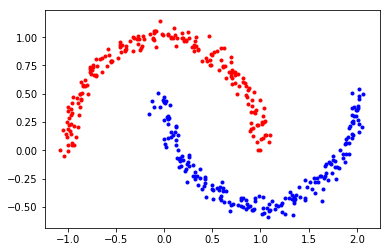

In [1]:
import numpy as np
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Load synthetic data and plot it [dataset1.mat, dataset2.mat, dataset3.mat, two_moons.mat, two_circles.mat]
data = sio.loadmat('datasets/two_moons.mat')
data1_true = np.array(data['x'].T)
data2_true = np.array(data['y'].T)
plt.scatter(data1_true[:, 0], data1_true[:, 1], c='r', marker='.');
plt.scatter(data2_true[:, 0], data2_true[:, 1], c='b', marker='.');

## Define functions for Spectral Clustering

In [2]:
def get_distance_matrix(data):
    """
    Get distance matrix between each point in matrix 'data'
    
    Args:
        data: 2D-matrix of shape (N * D) where N is the number of data and D is the dimension of data
    Returns:
        distance_mat: computed distance matrix of shape (N * N)
    """
    
    # Define N using the discription above with np.shape function
    N = data.shape[0]
    
    # Initialize distance matrix with zeros
    distance_mat = np.zeros((N, N))
    
    # Update distance matrix
    for n in range(N):
        distance_mat[:, n] = np.sum((data - data[n]) ** 2, axis=1)
    
    return distance_mat

def get_affinity_matrix(distance_mat, beta):
    """
    Args:
        distance_mat: distance matrix of shape (N, N)
        beta: hyperparameter >= 0
    Returns:
        affinity_mat: Affinity matrix of shape (N, N)
    """
    
    # Define N using the discription above with np.shape function
    N = distance_mat.shape[0]
    
    # Compute Affinity matrix and make diagonal elements 0
    affinity_mat = np.exp(-beta * distance_mat)
    affinity_mat[range(N), range(N)] = 0
    
    return affinity_mat

## Do spectral Clustering

In [3]:
# Merge the data to one matrix
data = np.vstack((data1_true, data2_true))

beta = 50
K = 2
N, D = data.shape

# Compute distance matrix
distance_mat = get_distance_matrix(data)
# Compute affinity matrix W
W = get_affinity_matrix(distance_mat, beta)
# Compute degree matrix D
D = np.diag(np.sum(W, axis=1))
# Get graph Laplacian
L = D - W

# Compute eigenvalues and coressponding eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(L)

# Get Fiedler Vector
ind = np.argsort(eigen_values)
fiedler = eigen_vectors[:, ind[1]]

## Compare true clusters and predicted clusters

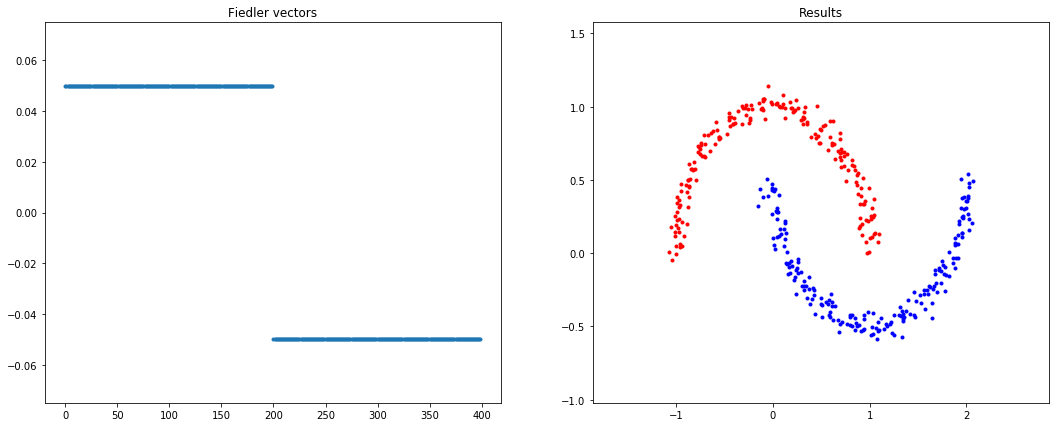

In [4]:
threshold = np.mean(fiedler)
predicted_cluster = fiedler >= threshold

# Plot the data and compare it with true labeled data
f, axarr = plt.subplots(1, 2, figsize=(18, 7))
axarr[0].scatter(range(len(fiedler)), fiedler, marker='.')
y_min = np.min(fiedler)
y_max = np.max(fiedler)
y_margin = (y_max - y_min) / 4
y_min = y_min - y_margin
y_max = y_max + y_margin
axarr[0].set_ylim([y_min, y_max]);
axarr[0].set_title('Fiedler vectors');

axarr[1].scatter(data[predicted_cluster, 0], data[predicted_cluster, 1], c='r', marker='.');
axarr[1].scatter(data[~predicted_cluster, 0], data[~predicted_cluster, 1], c='b', marker='.');
x_min = np.min(data[:, 0])
x_max = np.max(data[:, 0])
x_margin = (x_max - x_min) / 4
x_min = x_min - x_margin
x_max = x_max + x_margin
y_min = np.min(data[:, 1])
y_max = np.max(data[:, 1])
y_margin = (y_max - y_min) / 4
y_min = y_min - y_margin
y_max = y_max + y_margin
axarr[1].set_xlim([x_min, x_max]);
axarr[1].set_ylim([y_min, y_max]);
axarr[1].set_title('Results');

## Evaluate how well K-means clustered data

In [5]:
# Evaluate clustering performance using Normalized Mutual Information
def get_NMI(true_cluster, predicted_cluster, K):
    """
    Get Normalized Mutual Information
    
    Args:
        true_cluster: a vector of shape (N) that has elements assigned true cluster for each data point
        predicted_cluster: a vector of shape (N) that has elements assigned predicted cluster for each data point
        K: the number of clusters
    Returns:
        nmi: Normalized mutual information
    """
    # very little value to prevent logarithm from -infinity
    eps = 1e-10
    
    # Define the number of data
    N = float(data.shape[0])
    
    true_entropy = 0
    predicted_entropy = 0
    # Compute entropy for ground truth clusters and predicted clusters
    for k in range(K):
        true_ctr = np.sum(true_cluster == k)
        predicted_ctr = np.sum(predicted_cluster == k)
        true_entropy += -(true_ctr / N) * np.log2(true_ctr / N + eps)
        predicted_entropy += -(predicted_ctr / N) * np.log2(predicted_ctr / N + eps)
    
    denominator = (true_entropy + predicted_entropy) / 2.
    
    mi = 0
    # Compute mutual information between ground truth clusters and predicted clusters
    for i in range(K):
        for j in range(K):
            true_k = true_cluster == i
            predicted_k = predicted_cluster == j
            inter_ctr = np.sum(true_k & predicted_k)
            true_ctr = np.sum(true_k)
            predicted_ctr = np.sum(predicted_k)
            mi += (inter_ctr / N) * np.log2((N * inter_ctr) / (true_ctr * predicted_ctr) + eps)
    
    nmi = mi / denominator
    
    return nmi

true_cluster = np.concatenate((np.zeros(data1_true.shape[0]), np.ones(data2_true.shape[0])))
nmi = get_NMI(true_cluster, predicted_cluster, K)
print("Nomrlized Mutual Information: {}".format(nmi))

Nomrlized Mutual Information: 1.00000000036
